# Random Forest 
This Notebook presents tests to tune hyperparameters for a random forest model and present results obtained during training. The general description of a random forest model can be found in the report.

In [ ]:
import sys
sys.path.append('../src')
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from movies_preprocessing import full_processing
from dataset_split import train_test_split_perso
from evaluation import get_n_accuracies_test, get_n_accuracies_train

In [3]:
df = pd.read_csv('../data/training.csv')
features = ["year_film", "genres", "averageRating", "dir_won_before", "budget", "nb_actor_won_before","won_bafta","won_gg_drama","won_gg_comedy", "runtimeMinutes"]
X = df[features]
X_processed = full_processing(X, "median")
y = df['winner']

X_train, X_test, y_train, y_test = train_test_split_perso(df, X_processed, y, 0.2)

/Users/emile/Desktop/MLProject/Notebooks/../src/movies_preprocessing.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["genres_list"] = df["genres"].str.split(",")


# Baseline Model

As for Logistic Regression we start with a default baseline model to get a starting point and see how our model can be improved.

In [4]:
RF_base = RandomForestClassifier(class_weight='balanced')
RF_base.fit(X_train, y_train)
top1, top3 = get_n_accuracies_test(RF_base, df, X_processed, y, 100)
print(np.mean(top1), np.mean(top3))

0.4882352941176471 0.8605882352941179


## Hyper parameters tuning 
For Random Forest we can tune a certain number of hyperparameters. We will focus on the following:

- **The number of trees** used in the forest. Usually, the more trees the better. However, while having more trees does not lead to overfitting, it takes longer to train the model. We should choose a reasonable number that gives satisfying results without taking too much time to train.

- **The maximum depth** of the trees. This is a key to prevent overfitting. Deeper trees might give better results on the training set but could adapt poorly to new data.

- **The number of samples needed to split an internal node.** If we set it to 5, for example, any node with fewer than 5 samples becomes a leaf.

- **The number of features to consider** when looking for the best split. If we set it too high, trees might become too similar. If it is too low, we might underfit the data.

The last two do not seem to have a noticeable influence on the result for our task. We set the number of features to the standard default value, which is the square root of the total number of features.

To choose the best values for the maximum depth and the number of trees, we can use the same method as for logistic regression. The plots below display the average top-1 accuracy for the different (depth, number of trees) pairs on a hundred different training-validation splits.


In [5]:
#This loops can take a while to excute, the results can be seen on the plot below or directly in the report 
depths = [1,3, 5, None]
n_trees = [10, 50, 100, 200, 1000, 2000]
results_training = []
results_validation = []
for d in depths:
    for n in n_trees:
        model = RandomForestClassifier(n_estimators=n, max_depth=d, class_weight='balanced')
        
        # Compute training accuracy
        top1_train = get_n_accuracies_train(model, df, X_processed, y, 100)[0]
        results_training.append({
            'max_depth': d,
            'n_estimators': n,
            'top1_accuracy': np.mean(top1_train)
        })
        
        # Compute validation accuracy
        top1_val = get_n_accuracies_test(model, df, X_processed, y, 100)[0]
        results_validation.append({
            'max_depth': d,
            'n_estimators': n,
            'top1_accuracy': np.mean(top1_val)
        })

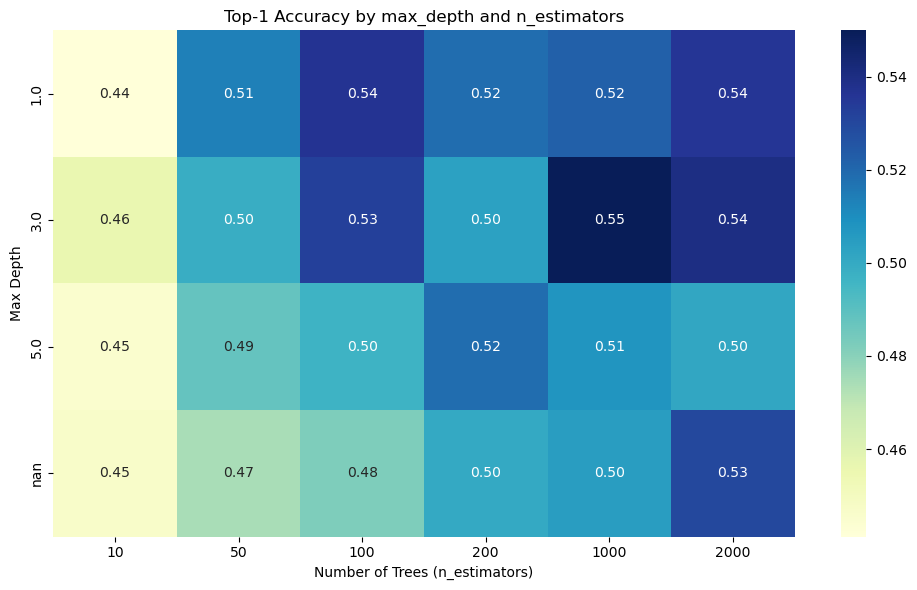

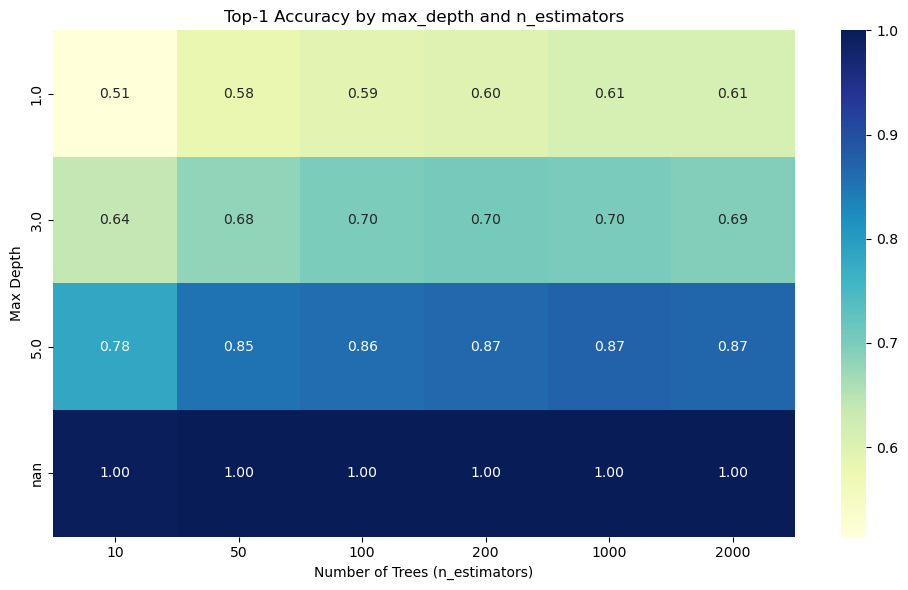

In [6]:
df_train = pd.DataFrame(results_training)
df_val = pd.DataFrame(results_validation)
df_val["max_depth"] = df_val["max_depth"].astype(str)
df_train["max_depth"] = df_train["max_depth"].astype(str)

train_pivot = df_train.pivot(index='max_depth', columns='n_estimators', values='top1_accuracy')
val_pivot = df_val.pivot(index='max_depth', columns='n_estimators', values='top1_accuracy')

#Plot for validation 
plt.figure(figsize=(10, 6))
sns.heatmap(val_pivot, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Top-1 Accuracy by max_depth and n_estimators")
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Max Depth")
plt.tight_layout()
plt.show()
plt.close()

#Plot for validation 
plt.figure(figsize=(10, 6))
sns.heatmap(train_pivot, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Top-1 Accuracy by max_depth and n_estimators")
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Max Depth")
plt.tight_layout()
plt.show()
plt.close()

## Results 
On the training set we can see that models with no depth limit can learn the data perfectly and get 100% accuracy. The number of trees has the expected influence, more trees give better results. The results are totally different on the validation set. When the tree is too deep it cannot adapt to the new data and performs really poorly. The number of trees behave as expected, we need a good amount of estimators but going for more than a thousand trees does not give better results but takes way more time to train. We can settle for a maximum depth of 3 and a thousand trees which gives satisfying and stable results. Compared to the plain random forest it seems to give slightly better results, 47 to 53% in top-1 accuracy and it could adapt better to new data since we limit the depth of the trees. We have similar results to the logistic regression even though they seem more stable.